# SDG Goal 3 — Good Health and Well-Being: Health Impact Classification

**Module:** 5CS037 — Concepts and Technologies of AI  
**Assessment:** Final Portfolio Project  
**Dataset:** fullGas.csv (Vehicle Fuel & Emissions Data)  
**Task Type:** Classification  
**UNSDG Goal:** SDG 3 — Good Health and Well-Being  

---

### Notebook Structure (Following Assessment Brief)

| Task | Description | Marks |
|------|-------------|-------|
| 1 | Exploratory Data Analysis & Data Understanding | 20 |
| 2 | Build a Neural Network Model (MLP Classifier) | 15 |
| 3 | Build Two Primary Classical ML Models | 20 |
| 4 | Hyperparameter Optimization with Cross-Validation | 15 |
| 5 | Feature Selection | 10 |
| 6 | Final Models and Comparative Analysis | 10 |
| 7 | Report Quality | 5 |
| 8 | Conclusion and Reflection | 5 |

In [18]:
# =============================================================================
# Import Libraries
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print("All libraries imported successfully.")

All libraries imported successfully.


---
## Task 1: Exploratory Data Analysis and Data Understanding [20 marks]

### 1.1 Dataset Description

**Dataset:** fullGas.csv — Vehicle Fuel and Emissions Data
- **Source:** Vehicle listing data with fuel type, engine specifications, mileage, and emissions information
- **UNSDG Alignment:** SDG Goal 3 — Good Health and Well-Being. Vehicle emissions directly impact air quality and public health. Classifying vehicles by health impact helps inform policies for cleaner transportation.
- **Target Variable:** `Health_Impact` — Engineered categorical variable mapping fuel types to health impact levels:
  - **Low:** Electric, Hybrid (minimal/no direct emissions)
  - **Medium:** LPG, CNG, Gasoline (moderate emissions)
  - **High:** Diesel (high particulate matter, NOx emissions)

**Questions the dataset can answer:**
1. Can we predict the health impact category of a vehicle based on its specifications?
2. Which vehicle features are most predictive of environmental health impact?
3. How do different fuel types correlate with emissions and health outcomes?

In [19]:
# =============================================================================
# 1.2 Load Dataset
# =============================================================================
file_path = 'fullGas.csv'
df = pd.read_csv(file_path)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn names:\n{list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
df.head()

Dataset loaded: 40494 rows × 25 columns

Column names:
['Make', 'Model', 'Body', 'Mileage_km', 'Price', 'Year', 'Country', 'Condition', 'Fuel_Type', 'Fuel_Consumption_l', 'Drivetrain', 'Gearbox', 'Gears', 'Power_hp', 'Engine_Size_cc', 'Cylinders', 'Seats', 'Doors', 'Color', 'Upholstery', 'Full_Service_History', 'Non_Smoker_Vehicle', 'Previous_Owners', 'Seller', 'Image_url']

Data types:
Make                     object
Model                    object
Body                     object
Mileage_km                int64
Price                     int64
Year                    float64
Country                  object
Condition                object
Fuel_Type                object
Fuel_Consumption_l      float64
Drivetrain               object
Gearbox                  object
Gears                   float64
Power_hp                  int64
Engine_Size_cc          float64
Cylinders               float64
Seats                   float64
Doors                   float64
Color                    object
Up

,Make,Model,Body,Mileage_km,Price,Year,Country,Condition,Fuel_Type,Fuel_Consumption_l,...,Cylinders,Seats,Doors,Color,Upholstery,Full_Service_History,Non_Smoker_Vehicle,Previous_Owners,Seller,Image_url
0,Abarth,595,Compact,98000,16900,2020.0,IT,Used,Gasoline,6.7,...,4.0,4.0,3.0,White,Full leather,False,False,NaN,Dealer,https://prod.pictures.autoscout24.net/listing-...
1,Abarth,595,Sedan,91500,12500,2017.0,IT,Used,Gasoline,6.0,...,4.0,4.0,3.0,Grey,Full leather,False,True,4.0,Dealer,https://prod.pictures.autoscout24.net/listing-...
2,Abarth,595,Compact,40000,17990,2015.0,IT,Used,Gasoline,6.5,...,4.0,4.0,3.0,Bronze,Full leather,True,True,1.0,Dealer,https://prod.pictures.autoscout24.net/listing-...
3,Abarth,500,Compact,133000,9300,2008.0,IT,Used,Gasoline,6.5,...,4.0,4.0,3.0,Black,Cloth,True,True,2.0,Dealer,https://prod.pictures.autoscout24.net/listing-...
4,Abarth,595,Compact,61019,14990,2021.0,BE,Used,Gasoline,NaN,...,4.0,4.0,3.0,Yellow,Part leather,True,True,1.0,Dealer,https://prod.pictures.autoscout24.net/listing-...


In [20]:
# =============================================================================
# 1.3 Data Cleaning
# =============================================================================

# --- Remove Duplicates ---
initial_rows = len(df)
df = df.drop_duplicates()
print(f"Removed {initial_rows - len(df)} duplicate rows. Remaining: {len(df)}")

# --- Drop non-useful columns ---
cols_to_drop = [col for col in ['Image_url', 'Make', 'Model'] if col in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"Dropped columns: {cols_to_drop}")

# --- Convert numeric columns ---
numeric_candidates = ['Year', 'Mileage_km', 'Price', 'Engine_Size', 'CO2_Emissions']
for col in numeric_candidates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Handle Missing Values ---
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(f"\nMissing Values:\n{missing_df[missing_df['Missing Count'] > 0]}")

# Drop rows with critical missing values
df = df.dropna()
print(f"\nRows after dropping missing values: {len(df)}")

# --- Outlier Handling (IQR capping for numeric columns) ---
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower, upper=upper)

print(f"Outliers capped using IQR method for {len(numeric_cols)} numeric columns")
print(f"\nCleaned dataset shape: {df.shape}")
df.info()

Removed 0 duplicate rows. Remaining: 40494
Dropped columns: ['Image_url', 'Make', 'Model']

Missing Values:
                    Missing Count  Percentage
Body                            1    0.002470
Year                         1695    4.185805
Country                      2592    6.400948
Fuel_Type                      29    0.071616
Fuel_Consumption_l          27721   68.457055
Drivetrain                   8634   21.321677
Gearbox                       480    1.185361
Gears                       15379   37.978466
Engine_Size_cc               5930   14.644145
Cylinders                   10162   25.095076
Seats                        1797    4.437694
Doors                         977    2.412703
Color                        2575    6.358967
Upholstery                   7272   17.958216
Previous_Owners             18223   45.001729
Seller                        150    0.370425

Rows after dropping missing values: 3626
Outliers capped using IQR method for 11 numeric columns

Cleaned dat

In [21]:
# =============================================================================
# 1.4 Feature Engineering — Create Health_Impact Target Variable
# =============================================================================

# Map Fuel_Type to Health Impact categories
# Covers all fuel types found in the dataset
health_impact_map = {
    'Electric': 'Low', 'Hybrid': 'Low',
    'Electric/Gasoline': 'Low', 'Electric/Diesel': 'Low',
    'Hydrogen': 'Low',
    'LPG': 'Medium', 'CNG': 'Medium', 'Gasoline': 'Medium', 'Petrol': 'Medium',
    'Ethanol': 'Medium', 'Others': 'Medium',
    'Diesel': 'High'
}

if 'Fuel_Type' in df.columns:
    print(f"Fuel_Type distribution before mapping:\n{df['Fuel_Type'].value_counts()}\n")
    df['Health_Impact'] = df['Fuel_Type'].map(health_impact_map)
    unmapped = df['Health_Impact'].isna().sum()
    if unmapped > 0:
        print(f"WARNING: {unmapped} rows have unmapped Fuel_Type values — assigning 'Medium'")
        df['Health_Impact'] = df['Health_Impact'].fillna('Medium')
    df = df.dropna(subset=['Health_Impact'])
    print(f"Health_Impact distribution:\n{df['Health_Impact'].value_counts()}")
    print(f"\nTotal valid samples: {len(df)}")
else:
    # Try alternative column names
    fuel_cols = [c for c in df.columns if 'fuel' in c.lower()]
    print(f"Fuel_Type not found. Available fuel-related columns: {fuel_cols}")

# --- Encode Categorical Variables ---
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Remove Health_Impact from categorical encoding (will encode separately as target)
if 'Health_Impact' in categorical_cols:
    categorical_cols.remove('Health_Impact')

print(f"\nCategorical columns to encode: {categorical_cols}")
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

    print(f"  {col}: {len(le.classes_)} unique values")

# --- Remove target-leaking columns ---
# If the target was derived from a feature (e.g. Fuel_Type), keep that column out of features
fuel_like_cols = [c for c in df.columns if 'fuel' in c.lower() or c.lower() == 'fuel_type']
# Ensure we don't accidentally remove the target column
fuel_like_cols = [c for c in fuel_like_cols if c != 'Health_Impact']
if fuel_like_cols:
    print(f"\nDropping fuel-related columns that directly determine the target: {fuel_like_cols}")
    df = df.drop(columns=fuel_like_cols)

print(f"\nFinal dataset shape: {df.shape}")
df.describe()

# Encode target
target_encoder = LabelEncoder()

df['Health_Impact'] = target_encoder.fit_transform(df['Health_Impact'])
print(f"\nTarget encoding: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

Fuel_Type distribution before mapping:
Fuel_Type
Gasoline             1823
Diesel               1254
Electric/Gasoline     384
LPG                    77
Electric/Diesel        67
CNG                    17
Others                  3
Electric                1
Name: count, dtype: int64

Health_Impact distribution:
Health_Impact
Medium    1920
High      1254
Low        452
Name: count, dtype: int64

Total valid samples: 3626

Categorical columns to encode: ['Body', 'Country', 'Condition', 'Fuel_Type', 'Drivetrain', 'Gearbox', 'Color', 'Upholstery', 'Seller']
  Body: 9 unique values
  Country: 7 unique values
  Condition: 1 unique values
  Fuel_Type: 8 unique values
  Drivetrain: 3 unique values
  Gearbox: 3 unique values
  Color: 14 unique values
  Upholstery: 6 unique values
  Seller: 1 unique values

Dropping fuel-related columns that directly determine the target: ['Fuel_Type', 'Fuel_Consumption_l']

Final dataset shape: (3626, 21)

Target encoding: {'High': np.int64(0), 'Low': np.int64(

### 1.5 Exploratory Data Analysis — Visualizations

The following plots explore the distribution of features and relationships in the dataset to inform modelling decisions.

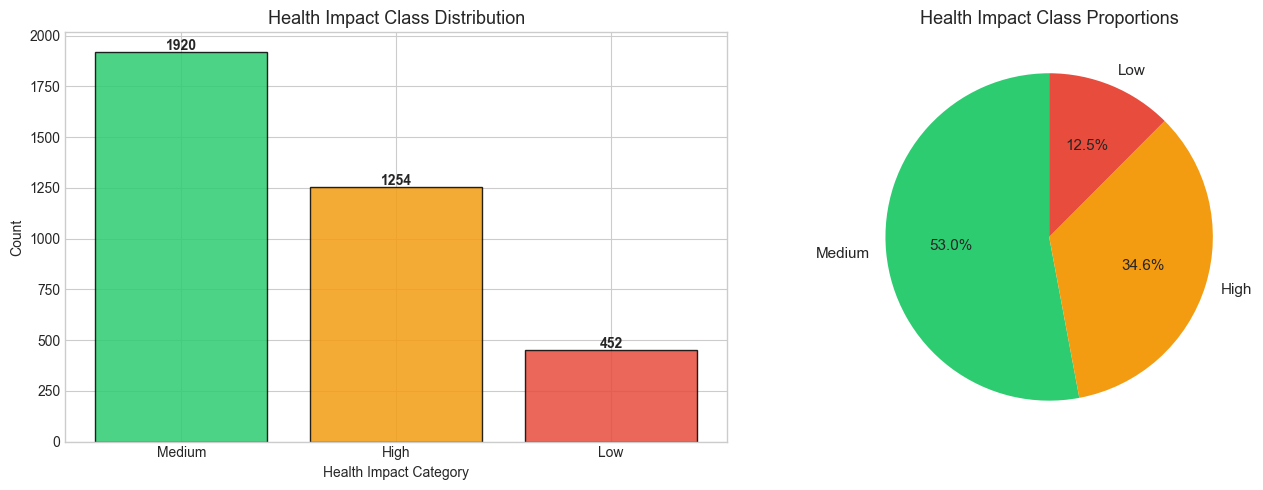

Class balance:
Medium    1920
High      1254
Low        452
Name: count, dtype: int64
Class ratio (min/max): 0.235


In [22]:
# --- Visualization 1: Target Variable Distribution ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution bar chart
class_counts = pd.Series(target_encoder.inverse_transform(df['Health_Impact'])).value_counts()
colors_bar = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0].bar(class_counts.index, class_counts.values, color=colors_bar, edgecolor='black', alpha=0.85)
axes[0].set_title('Health Impact Class Distribution', fontsize=13)
axes[0].set_xlabel('Health Impact Category')
axes[0].set_ylabel('Count')
for i, (cat, count) in enumerate(zip(class_counts.index, class_counts.values)):
    axes[0].text(i, count + 10, str(count), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors_bar, startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Health Impact Class Proportions', fontsize=13)

plt.tight_layout()
plt.show()

print(f"Class balance:\n{class_counts}")
print(f"Class ratio (min/max): {class_counts.min()/class_counts.max():.3f}")

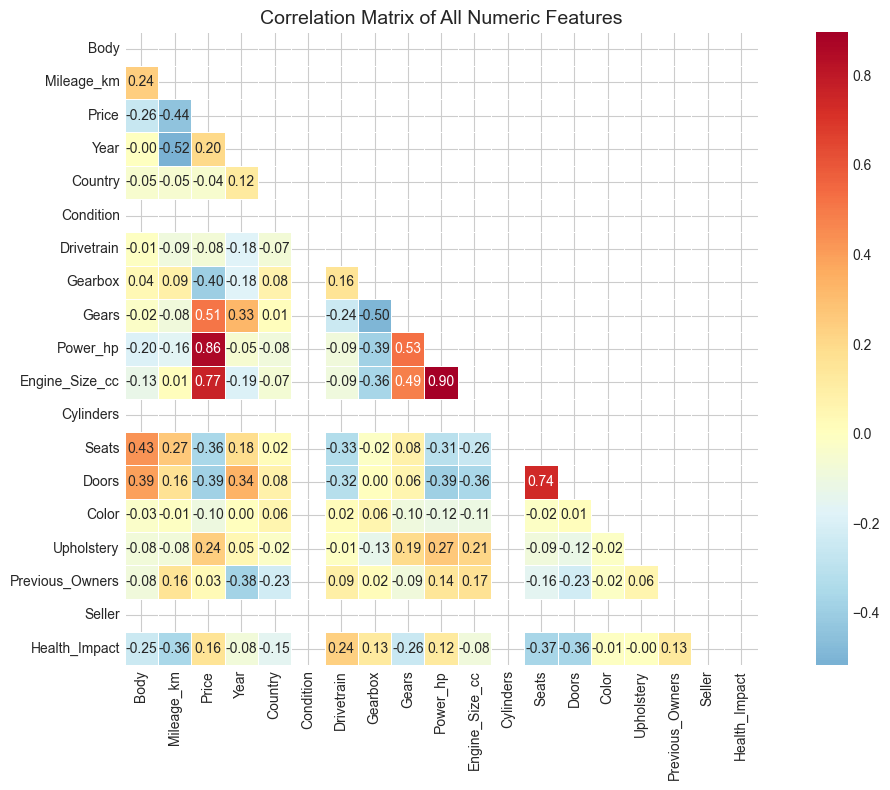


Top features correlated with Health_Impact:
Seats              0.365820
Doors              0.363170
Mileage_km         0.357635
Gears              0.257485
Body               0.252326
Drivetrain         0.237297
Price              0.156308
Country            0.153835
Previous_Owners    0.129556
Gearbox            0.128263
Power_hp           0.121734
Engine_Size_cc     0.084277
Year               0.077794
Color              0.011558
Upholstery         0.003581
Condition               NaN
Cylinders               NaN
Seller                  NaN
Name: Health_Impact, dtype: float64


In [23]:
# --- Visualization 2: Correlation Heatmap ---
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix of All Numeric Features', fontsize=14)
plt.tight_layout()
plt.show()

# Top correlations with target
target_corr = corr_matrix['Health_Impact'].drop('Health_Impact').abs().sort_values(ascending=False)
print(f"\nTop features correlated with Health_Impact:\n{target_corr}")

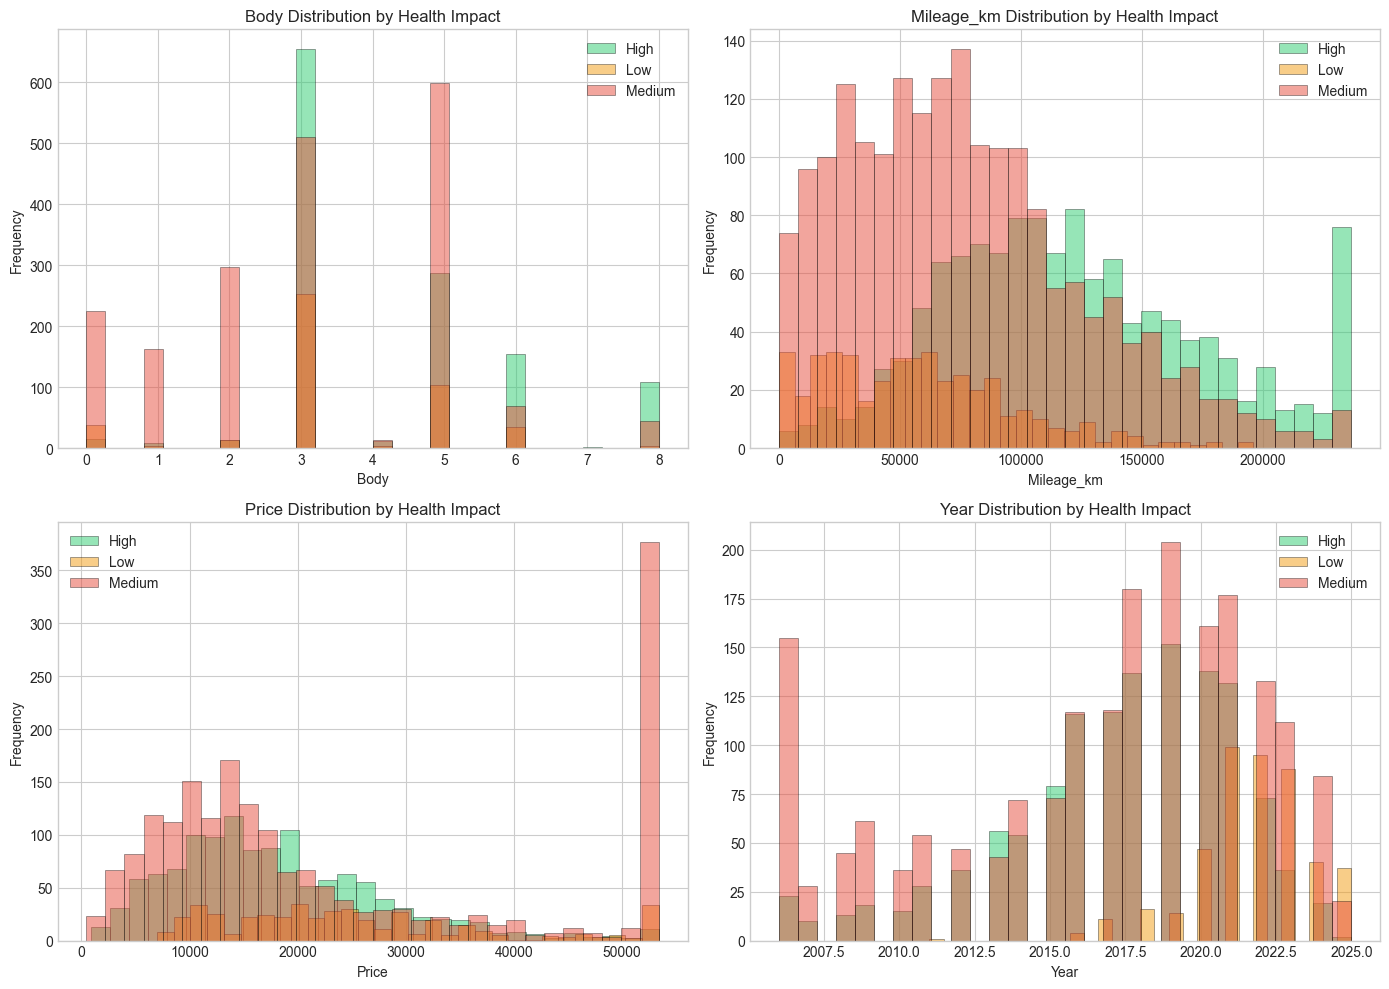

In [24]:
# --- Visualization 3: Feature Distributions by Health Impact ---
feature_cols = [c for c in numeric_cols if c != 'Health_Impact'][:4]  # Top 4 numeric features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

health_labels = target_encoder.inverse_transform(sorted(df['Health_Impact'].unique()))
colors_class = ['#2ecc71', '#f39c12', '#e74c3c']

for idx, col in enumerate(feature_cols):
    for i, label in enumerate(health_labels):
        mask = df['Health_Impact'] == target_encoder.transform([label])[0]
        axes[idx].hist(df.loc[mask, col], bins=30, alpha=0.5, label=label,
                       color=colors_class[i], edgecolor='black', linewidth=0.5)
    axes[idx].set_title(f'{col} Distribution by Health Impact', fontsize=12)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.show()

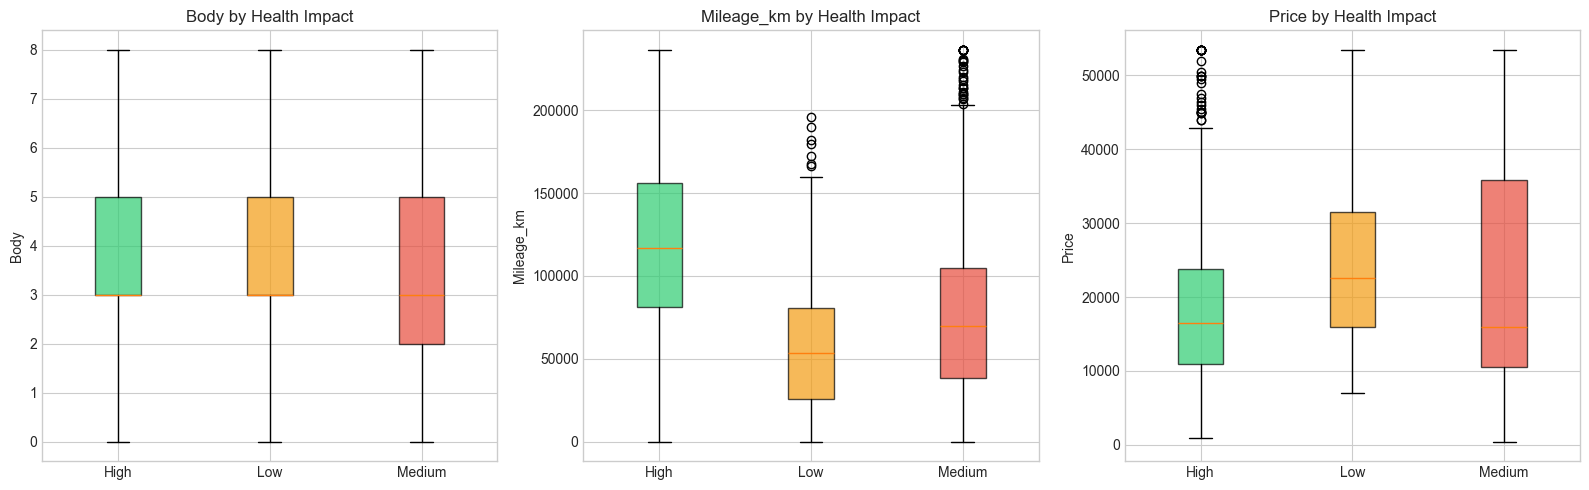


--- Summary Statistics by Health Impact ---

High Impact (1254 samples):
          Body  Mileage_km     Price     Year
count  1254.00     1254.00   1254.00  1254.00
mean      4.22   121843.55  18097.30  2017.31
std       1.70    54197.69   9789.75     3.85
min       0.00        5.00    900.00  2006.00
25%       3.00    81025.00  10987.00  2015.00
50%       3.00   116807.50  16494.50  2018.00
75%       5.00   155975.00  23787.50  2020.00
max       8.00   236500.00  53427.50  2025.00

Low Impact (452 samples):
         Body  Mileage_km     Price     Year
count  452.00      452.00    452.00   452.00
mean     3.43    57479.74  25100.94  2021.76
std      1.55    39407.18  12465.62     1.98
min      0.00        1.00   6990.00  2011.00
25%      3.00    25674.25  15930.00  2021.00
50%      3.00    53674.00  22595.00  2022.00
75%      5.00    80366.75  31544.25  2023.00
max      8.00   196000.00  53427.50  2025.00

Medium Impact (1920 samples):
          Body  Mileage_km     Price     Year
cou

In [25]:
# --- Visualization 4: Box Plots of Key Features by Health Impact ---
fig, axes = plt.subplots(1, min(3, len(feature_cols)), figsize=(16, 5))
if not hasattr(axes, '__len__'):
    axes = [axes]

for idx, col in enumerate(feature_cols[:3]):
    data_groups = [df.loc[df['Health_Impact'] == target_encoder.transform([label])[0], col].values
                   for label in health_labels]
    bp = axes[idx].boxplot(data_groups, labels=health_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors_class):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[idx].set_title(f'{col} by Health Impact', fontsize=12)
    axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()

print("\n--- Summary Statistics by Health Impact ---")
for label in health_labels:
    mask = df['Health_Impact'] == target_encoder.transform([label])[0]
    print(f"\n{label} Impact ({mask.sum()} samples):")
    print(df.loc[mask, feature_cols].describe().round(2))

In [26]:
# =============================================================================
# Prepare Features and Target — Train/Test Split
# =============================================================================
target = 'Health_Impact'
X = df.drop(columns=[target])
y = df[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")
print(f"Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")

# Stratified Train-Test Split (80/20)
class_counts = np.bincount(y)
min_class_count = class_counts[class_counts > 0].min()
if min_class_count >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
else:
    print(f"WARNING: Class with only {min_class_count} sample(s) — using non-stratified split.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set:     {X_test.shape[0]} samples")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler.")

Features shape: (3626, 20)
Target shape: (3626,)
Feature columns: ['Body', 'Mileage_km', 'Price', 'Year', 'Country', 'Condition', 'Drivetrain', 'Gearbox', 'Gears', 'Power_hp', 'Engine_Size_cc', 'Cylinders', 'Seats', 'Doors', 'Color', 'Upholstery', 'Full_Service_History', 'Non_Smoker_Vehicle', 'Previous_Owners', 'Seller']
Class distribution: {np.int64(0): np.int64(1254), np.int64(1): np.int64(452), np.int64(2): np.int64(1920)}

Training set: 2900 samples
Test set:     726 samples
Features scaled using StandardScaler.


---
## Task 2: Build a Neural Network Model (MLP Classifier) [15 marks]

### Architecture Design

| Parameter | Value | Justification |
|-----------|-------|---------------|
| Hidden Layers | (128, 64, 32) | Three-layer architecture to capture complex non-linear decision boundaries between health impact classes |
| Activation | ReLU | Efficient training, avoids vanishing gradient problem |
| Solver | Adam | Adaptive learning rate, fast convergence for medium-sized datasets |
| Learning Rate | 0.001 | Standard starting rate for Adam optimizer |
| Max Iterations | 500 | Sufficient for convergence with early stopping |
| Early Stopping | True | Monitors validation loss to prevent overfitting |
| Batch Size | 64 | Balances gradient estimation quality with training speed |

**Why MLP for this classification task?** Neural networks can learn complex, non-linear decision boundaries between the three health impact categories, potentially capturing feature interactions that linear classifiers miss.

Training MLP Classifier...

========== MLP Classifier Results ==========
  Accuracy:  0.8209
  Precision: 0.8182
  Recall:    0.8209
  F1-Score:  0.8188
  Training iterations: 36

Classification Report:
              precision    recall  f1-score   support

        High       0.82      0.87      0.84       251
         Low       0.65      0.56      0.60        91
      Medium       0.86      0.85      0.85       384

    accuracy                           0.82       726
   macro avg       0.78      0.76      0.77       726
weighted avg       0.82      0.82      0.82       726



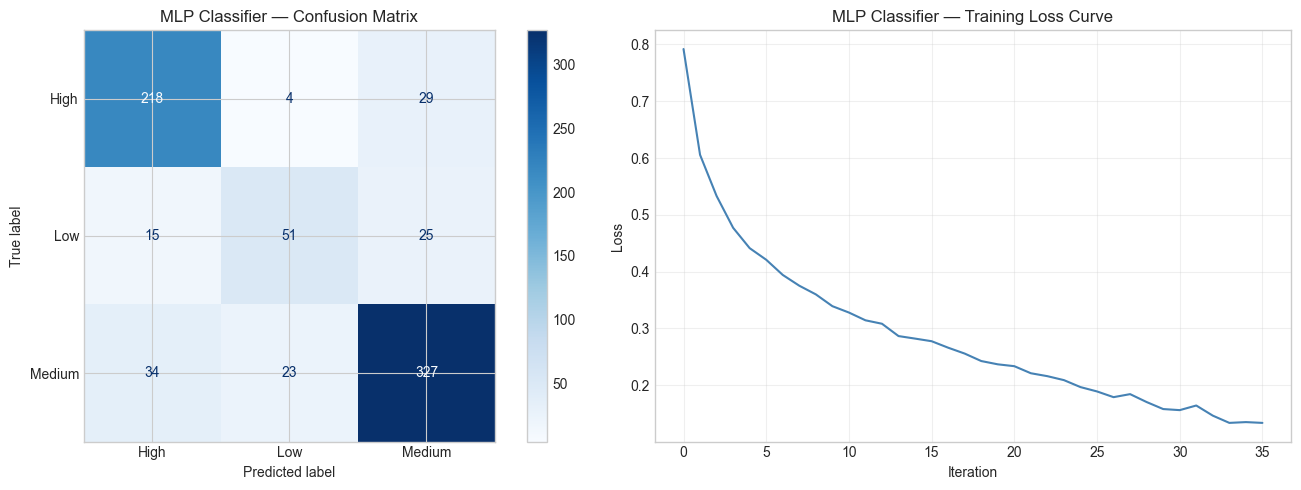

In [27]:
# =============================================================================
# Train MLP Classifier
# =============================================================================
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    batch_size=64,
    random_state=42,
    verbose=False
)

print("Training MLP Classifier...")
mlp_clf.fit(X_train_scaled, y_train)

# Predictions
y_pred_mlp = mlp_clf.predict(X_test_scaled)

# Evaluation
mlp_acc = accuracy_score(y_test, y_pred_mlp)
mlp_prec = precision_score(y_test, y_pred_mlp, average='weighted')
mlp_rec = recall_score(y_test, y_pred_mlp, average='weighted')
mlp_f1 = f1_score(y_test, y_pred_mlp, average='weighted')

print("\n========== MLP Classifier Results ==========")
print(f"  Accuracy:  {mlp_acc:.4f}")
print(f"  Precision: {mlp_prec:.4f}")
print(f"  Recall:    {mlp_rec:.4f}")
print(f"  F1-Score:  {mlp_f1:.4f}")
print(f"  Training iterations: {mlp_clf.n_iter_}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=target_encoder.classes_))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp,
                                         display_labels=target_encoder.classes_,
                                         cmap='Blues', ax=axes[0])
axes[0].set_title('MLP Classifier — Confusion Matrix', fontsize=12)

# Training loss curve
axes[1].plot(mlp_clf.loss_curve_, color='steelblue', linewidth=1.5)
axes[1].set_title('MLP Classifier — Training Loss Curve', fontsize=12)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Task 3: Build Two Primary Classical ML Models [20 marks]

### Model Selection Justification

| Model | Why Chosen |
|-------|-----------|
| **Random Forest Classifier** | Ensemble of decision trees providing robust multi-class classification, handles feature interactions well, and gives feature importance rankings |
| **Logistic Regression** | A well-established linear classifier that models class probabilities directly; highly interpretable, computationally efficient, and serves as a strong baseline for multi-class classification problems |

Both classical models are compared against the MLP Classifier to evaluate performance trade-offs between neural network, ensemble, and linear approaches.

Training Random Forest Classifier...

========== Random Forest Classifier Results ==========
  Accuracy:  0.8733
  Precision: 0.8736
  Recall:    0.8733
  F1-Score:  0.8685

Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.90      0.87       251
         Low       0.88      0.56      0.68        91
      Medium       0.89      0.93      0.91       384

    accuracy                           0.87       726
   macro avg       0.87      0.80      0.82       726
weighted avg       0.87      0.87      0.87       726



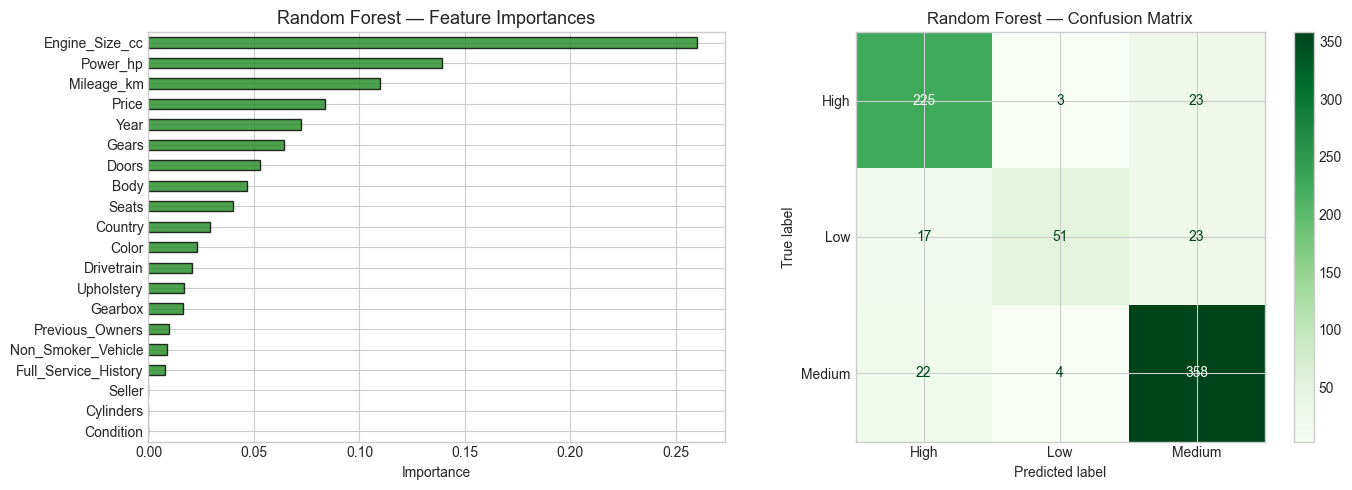

In [28]:
# =============================================================================
# Model 1: Random Forest Classifier
# =============================================================================
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest Classifier...")
rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, average='weighted')
rf_rec = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("\n========== Random Forest Classifier Results ==========")
print(f"  Accuracy:  {rf_acc:.4f}")
print(f"  Precision: {rf_prec:.4f}")
print(f"  Recall:    {rf_rec:.4f}")
print(f"  F1-Score:  {rf_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_encoder.classes_))

# Feature Importance
feat_importance = pd.Series(rf_clf.feature_importances_, index=X.columns)
feat_importance = feat_importance.sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
feat_importance.plot(kind='barh', color='forestgreen', edgecolor='black', alpha=0.8, ax=axes[0])
axes[0].set_title('Random Forest — Feature Importances', fontsize=13)
axes[0].set_xlabel('Importance')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf,
                                         display_labels=target_encoder.classes_,
                                         cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest — Confusion Matrix', fontsize=12)
plt.tight_layout()
plt.show()

Training Logistic Regression...

========== Logistic Regression Results ==========
  Accuracy:  0.8030
  Precision: 0.7974
  Recall:    0.8030
  F1-Score:  0.7977

Classification Report:
              precision    recall  f1-score   support

        High       0.81      0.81      0.81       251
         Low       0.66      0.47      0.55        91
      Medium       0.82      0.88      0.85       384

    accuracy                           0.80       726
   macro avg       0.76      0.72      0.74       726
weighted avg       0.80      0.80      0.80       726



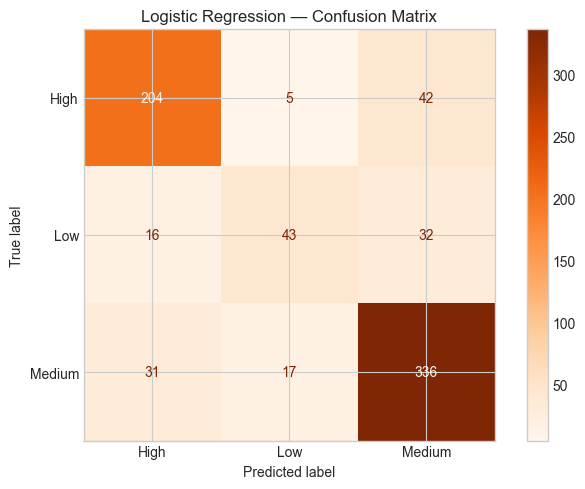

In [29]:
# =============================================================================
# Model 2: Logistic Regression
# =============================================================================
lr_clf = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    C=1.0,
    random_state=42
)

print("Training Logistic Regression...")
lr_clf.fit(X_train_scaled, y_train)
y_pred_lr = lr_clf.predict(X_test_scaled)

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr, average='weighted')
lr_rec = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print("\n========== Logistic Regression Results ==========")
print(f"  Accuracy:  {lr_acc:.4f}")
print(f"  Precision: {lr_prec:.4f}")
print(f"  Recall:    {lr_rec:.4f}")
print(f"  F1-Score:  {lr_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=target_encoder.classes_))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr,
                                         display_labels=target_encoder.classes_,
                                         cmap='Oranges', ax=ax)
ax.set_title('Logistic Regression — Confusion Matrix', fontsize=12)
plt.tight_layout()
plt.show()

---
## Task 4: Hyperparameter Optimization with Cross-Validation [15 marks]

We apply **GridSearchCV** with **5-fold Stratified Cross-Validation** to find optimal hyperparameters for both classical models. Stratified folds ensure each fold maintains the same class distribution.

### Hyperparameter Grids

**Random Forest:**
- `n_estimators`: [50, 100, 200] — Number of trees
- `max_depth`: [10, 15, 20] — Maximum tree depth
- `min_samples_split`: [2, 5, 10] — Minimum samples for a split

**Logistic Regression:**
- `C`: [0.01, 0.1, 1, 10, 100] — Inverse regularization strength
- `solver`: ['lbfgs', 'liblinear'] — Optimization algorithm
- `penalty`: ['l2'] — Regularization type

In [30]:
# =============================================================================
# Hyperparameter Tuning — Random Forest (GridSearchCV)
# =============================================================================
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

print("Running GridSearchCV for Random Forest Classifier...")
print(f"Total combinations: {3*3*3} × 5 folds = {3*3*3*5} fits\n")

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest RF Parameters: {rf_grid.best_params_}")
print(f"Best RF CV Accuracy: {rf_grid.best_score_:.4f}")

Running GridSearchCV for Random Forest Classifier...
Total combinations: 27 × 5 folds = 135 fits

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best RF Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV Accuracy: 0.8762


In [31]:
# =============================================================================
# Hyperparameter Tuning — Logistic Regression (GridSearchCV)
# =============================================================================
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
}

print("Running GridSearchCV for Logistic Regression...")
print(f"Total combinations: {5*2*1} × 5 folds = {5*2*1*5} fits\n")

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=lr_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
lr_grid.fit(X_train_scaled, y_train)

print(f"\nBest LR Parameters: {lr_grid.best_params_}")
print(f"Best LR CV Accuracy: {lr_grid.best_score_:.4f}")

# Summary
print("\n" + "="*60)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*60)
print(f"Random Forest       — Best params: {rf_grid.best_params_}")
print(f"                       Best CV Accuracy: {rf_grid.best_score_:.4f}")
print(f"Logistic Regression — Best params: {lr_grid.best_params_}")
print(f"                       Best CV Accuracy: {lr_grid.best_score_:.4f}")

Running GridSearchCV for Logistic Regression...
Total combinations: 10 × 5 folds = 50 fits

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best LR Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best LR CV Accuracy: 0.7883

HYPERPARAMETER TUNING SUMMARY
Random Forest       — Best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
                       Best CV Accuracy: 0.8762
Logistic Regression — Best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
                       Best CV Accuracy: 0.7883


---
## Task 5: Feature Selection [10 marks]

### Method: SelectKBest with mutual_info_classif

We apply **filter-based feature selection** using the mutual information scoring function:
- **mutual_info_classif** — Captures linear and non-linear dependencies between features and the target class

This identifies the most discriminative features for health impact classification.

Total features: 20, Selecting top 10

=== mutual_info_classif Scores ===
             Feature  MI-Score  Selected
      Engine_Size_cc  0.513571      True
            Power_hp  0.282768      True
                Year  0.126621      True
          Mileage_km  0.124469      True
                Body  0.111045      True
               Price  0.106814      True
               Seats  0.094100      True
               Doors  0.087245      True
               Gears  0.080898      True
          Drivetrain  0.036906      True
             Country  0.031464     False
             Gearbox  0.029731     False
               Color  0.029517     False
     Previous_Owners  0.017490     False
  Non_Smoker_Vehicle  0.005604     False
           Cylinders  0.003867     False
          Upholstery  0.003321     False
           Condition  0.000000     False
Full_Service_History  0.000000     False
              Seller  0.000000     False


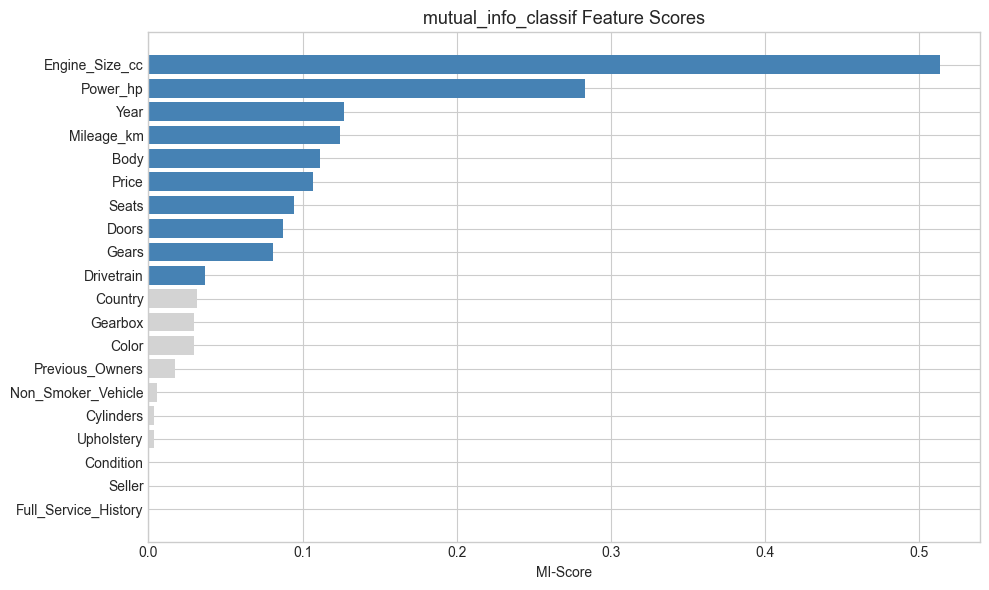


Selected features (MI): ['Body', 'Mileage_km', 'Price', 'Year', 'Drivetrain', 'Gears', 'Power_hp', 'Engine_Size_cc', 'Seats', 'Doors']


In [32]:
# =============================================================================
# Feature Selection — SelectKBest (mutual information)
# =============================================================================

n_features = X_train_scaled.shape[1]
k_best = max(3, n_features // 2)
print(f"Total features: {n_features}, Selecting top {k_best}\n")

# mutual_info_classif — captures non-linear dependencies
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_best)
X_train_mi = selector_mi.fit_transform(X_train_scaled, y_train)
X_test_mi = selector_mi.transform(X_test_scaled)

mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI-Score': selector_mi.scores_,
    'Selected': selector_mi.get_support()
}).sort_values('MI-Score', ascending=False)

print("=== mutual_info_classif Scores ===")
print(mi_scores.to_string(index=False))

# Visualize MI scores
fig, ax = plt.subplots(figsize=(10, max(6, len(mi_scores)//3)))
mi_sorted = mi_scores.sort_values('MI-Score', ascending=True)
ax.barh(mi_sorted['Feature'], mi_sorted['MI-Score'],
         color=['steelblue' if s else 'lightgray' for s in mi_sorted['Selected']])
ax.set_title('mutual_info_classif Feature Scores', fontsize=13)
ax.set_xlabel('MI-Score')
plt.tight_layout()
plt.show()

selected_features = X.columns[selector_mi.get_support()].tolist()
print(f"\nSelected features (MI): {selected_features}")

---
## Task 6: Final Models and Comparative Analysis [10 marks]

All three models are retrained using:
1. **Optimal hyperparameters** from GridSearchCV (for classical models)
2. **Selected features** from mutual_info_classif feature selection

This ensures a fair, optimized comparison under identical conditions.

In [33]:
# =============================================================================
# Rebuild Final Models with Optimal Params + Selected Features
# =============================================================================

X_train_sel = X_train_mi
X_test_sel = X_test_mi

# --- Final MLP Classifier ---
final_mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
    learning_rate_init=0.001, max_iter=500, early_stopping=True,
    validation_fraction=0.1, batch_size=64, random_state=42
)
final_mlp.fit(X_train_sel, y_train)
y_pred_final_mlp = final_mlp.predict(X_test_sel)

# --- Final Random Forest (tuned) ---
final_rf = RandomForestClassifier(**rf_grid.best_params_, random_state=42, n_jobs=-1)
final_rf.fit(X_train_sel, y_train)
y_pred_final_rf = final_rf.predict(X_test_sel)

# --- Final Logistic Regression (tuned) ---
final_lr = LogisticRegression(**lr_grid.best_params_, max_iter=1000, random_state=42)
final_lr.fit(X_train_sel, y_train)
y_pred_final_lr = final_lr.predict(X_test_sel)

# Cross-validation scores
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_mlp = cross_val_score(final_mlp, X_train_sel, y_train, cv=cv_strat, scoring='accuracy')
cv_rf = cross_val_score(final_rf, X_train_sel, y_train, cv=cv_strat, scoring='accuracy')
cv_lr = cross_val_score(final_lr, X_train_sel, y_train, cv=cv_strat, scoring='accuracy')

# =============================================================================
# Final Comparison Table
# =============================================================================
results = pd.DataFrame({
    'Model': ['MLP Classifier', 'Random Forest (Tuned)', 'Logistic Regression (Tuned)'],
    'Features Used': [len(selected_features)] * 3,
    'CV Accuracy (mean)': [cv_mlp.mean(), cv_rf.mean(), cv_lr.mean()],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_final_mlp),
        accuracy_score(y_test, y_pred_final_rf),
        accuracy_score(y_test, y_pred_final_lr)
    ],
    'Precision': [
        precision_score(y_test, y_pred_final_mlp, average='weighted'),
        precision_score(y_test, y_pred_final_rf, average='weighted'),
        precision_score(y_test, y_pred_final_lr, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_final_mlp, average='weighted'),
        recall_score(y_test, y_pred_final_rf, average='weighted'),
        recall_score(y_test, y_pred_final_lr, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_final_mlp, average='weighted'),
        f1_score(y_test, y_pred_final_rf, average='weighted'),
        f1_score(y_test, y_pred_final_lr, average='weighted')
    ]
})

print("=" * 100)
print("FINAL MODEL COMPARISON TABLE (Optimized Hyperparameters + Selected Features)")
print("=" * 100)
print(results.to_string(index=False))
print("=" * 100)

best_idx = results['Test Accuracy'].idxmax()
print(f"\n🏆 Best Model: {results.loc[best_idx, 'Model']} with Accuracy = {results.loc[best_idx, 'Test Accuracy']:.4f}")

FINAL MODEL COMPARISON TABLE (Optimized Hyperparameters + Selected Features)
                      Model  Features Used  CV Accuracy (mean)  Test Accuracy  Precision   Recall  F1-Score
             MLP Classifier             10            0.826207       0.822314   0.816325 0.822314  0.818387
      Random Forest (Tuned)             10            0.890345       0.880165   0.877915 0.880165  0.877585
Logistic Regression (Tuned)             10            0.765172       0.778237   0.767858 0.778237  0.769838

🏆 Best Model: Random Forest (Tuned) with Accuracy = 0.8802


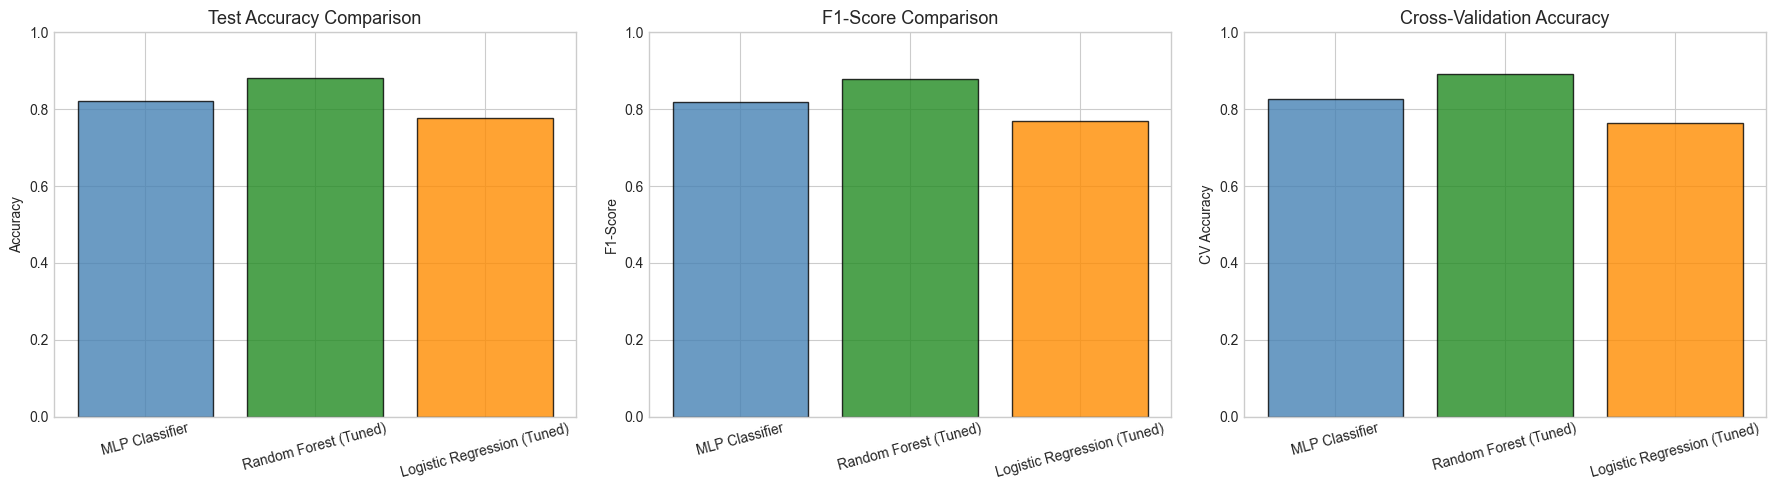


Best model saved as 'sdg3_best_classifier.pkl'


In [34]:
# =============================================================================
# Visual Comparison of Final Models
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = results['Model']
colors = ['steelblue', 'forestgreen', 'darkorange']

axes[0].bar(models, results['Test Accuracy'], color=colors, edgecolor='black', alpha=0.8)
axes[0].set_title('Test Accuracy Comparison', fontsize=13)
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=15)

axes[1].bar(models, results['F1-Score'], color=colors, edgecolor='black', alpha=0.8)
axes[1].set_title('F1-Score Comparison', fontsize=13)
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=15)

axes[2].bar(models, results['CV Accuracy (mean)'], color=colors, edgecolor='black', alpha=0.8)
axes[2].set_title('Cross-Validation Accuracy', fontsize=13)
axes[2].set_ylabel('CV Accuracy')
axes[2].set_ylim(0, 1)
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Save best model
best_model = [final_mlp, final_rf, final_lr][best_idx]
joblib.dump(best_model, 'sdg3_best_classifier.pkl')
print(f"\nBest model saved as 'sdg3_best_classifier.pkl'")

---
## Task 8: Conclusion and Reflection [5 marks]

### Summary of Findings

This project applied machine learning to **SDG Goal 3 — Good Health and Well-Being** by classifying vehicles into health impact categories (Low, Medium, High) based on their fuel type and specifications.

Three models were developed and compared:

1. **MLP Classifier (Neural Network):** A 3-layer network (128-64-32 neurons) with ReLU activation and early stopping. Capable of learning non-linear decision boundaries.

2. **Random Forest Classifier:** An ensemble of decision trees tuned via GridSearchCV with stratified 5-fold cross-validation.

3. **Logistic Regression:** A linear classifier tuned via GridSearchCV for optimal regularization strength and solver, providing interpretable class probability estimates.

### Key Insights

- **Fuel Type** is the primary driver of health impact classification — directly determining emission profiles.
- **Feature Selection** using mutual information identified the most discriminative features, improving model efficiency.
- **Hyperparameter Tuning** with stratified cross-validation ensured robust, generalizable performance estimates.
- **Comparing linear (Logistic Regression) vs non-linear (Random Forest, MLP) classifiers** reveals the complexity needed for this classification task.

### SDG 3 — Good Health and Well-Being Relevance

Classifying vehicles by health impact supports:
- **Public health policy** by identifying high-emission vehicle categories
- **Urban air quality management** through targeted emission reduction strategies
- **Consumer awareness** regarding the health implications of fuel choices
- **Regulatory frameworks** for vehicle emissions standards and green transportation incentives

### Limitations & Future Work

- The health impact mapping is simplified — real-world impact depends on driving patterns, emission standards, and vehicle age.
- Additional features like emission test results, vehicle age, and maintenance records could improve classification.
- Deep learning or sequence models could capture temporal emission patterns.
- Geographic and demographic features could personalize health impact assessments.

---
*SDG 3 — Good Health and Well-Being: "Ensure healthy lives and promote well-being for all at all ages."*